# TSA GARCH- PYTHON IMPLEMENTATION
Michał Budasz, Lidia Szmytkowska, Igor Bałys

The analysis concerns the listing of Activision Blizzard, Inc. (ATVI), a US company that produces and distributes video games. The data, on adaily basis, can be found on Yahoo Finance (<https://finance.yahoo.com/quote/AIY.DE/history/>).
It is worth mentioning that Blizzard Entertainment was acquired by Microsoft- the acquisition was completed on October 13, 2023 and it was the largest acquisition in video game history!
Latest stock valuation dates for October 22, 2024, but our time series is in range from 5 January 2015 to 31 December 2021 (1762 observations). 
The available variables are: 
“open"-the opening prices, 
“close”- the closing prices, 
“high”- the highest price, 
“low”- the lowest price, 
“volume”- number of shares traded, 
“adjusted”- “close” prices adjusted for dividends. 
The objective of the analysis is to forecast volatility in the next 10 days from 1 January 2022 to 12 January 2022
(including only trading days, that is excluding Saturdays and Sundays)

In [57]:
#!pip install importnb
#!pip install arch

In [80]:
#Loading libraries and setting global functions

import pandas as pd # for data processing
import numpy as np # here mostly for series generation
import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
import sys
import os #for setting dependencies

from importnb import Notebook #for importing functions from other notebooks
from arch import arch_model
from arch.univariate import ConstantMean, ARX, GARCH, EGARCH, ARCHInMean, StudentsT, Normal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from scipy.stats import norm
from scipy.special import beta
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import jarque_bera
from IPython.display import Markdown
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import probplot
from sklearn.preprocessing import StandardScaler

import yfinance as yf # for importing data directly from finance.yahoo.com
import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
#Loading data
df = pd.read_csv("ATVI.csv") 

In [81]:
#Importing global functions
sys.path.append('Functions_Python')  # Add the folder to the import path

with Notebook():
    import TSA_Finance_Functions  

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-03,12.5700000000,12.6000000000,12.4200000000,12.5200000000,11.3181390000,11721500
1,2011-01-04,12.5500000000,12.6400000000,12.4000000000,12.5300000000,11.3271780000,8107400
2,2011-01-05,12.4000000000,12.4600000000,12.1900000000,12.2900000000,11.1102180000,11162000
3,2011-01-06,12.3100000000,12.3400000000,12.1400000000,12.2600000000,11.0830970000,4386600
4,2011-01-07,12.2900000000,12.2900000000,12.0700000000,12.1000000000,10.9384570000,7033600


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2769 non-null   object 
 1   Open       2769 non-null   float64
 2   High       2769 non-null   float64
 3   Low        2769 non-null   float64
 4   Close      2769 non-null   float64
 5   Adj Close  2769 non-null   float64
 6   Volume     2769 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 151.6+ KB


In [9]:
# Convert the `Date` column to datetime
df['Date'] = pd.to_datetime(df['Date'])
print(df.info())

# Set the `Date` column as the index
df.set_index('Date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2769 non-null   datetime64[ns]
 1   Open       2769 non-null   float64       
 2   High       2769 non-null   float64       
 3   Low        2769 non-null   float64       
 4   Close      2769 non-null   float64       
 5   Adj Close  2769 non-null   float64       
 6   Volume     2769 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 151.6 KB
None


In [10]:
#Adding variables and transformation of dataset
df.rename(columns={'Adj Close': 'Adjusted'}, inplace=True)
df['cc_ret'] = np.log(df['Adjusted']).diff()
df['gkVol']=TSA_Finance_Functions.garman_klass(data=df)

- cc.ret are the close-to-close returns: log(close price
  today/yesterday)
- gkVol is the garman klass volatility, really useful since it accounts
  for open, high, low, and closing prices, defined in the 'TSA_Finance_Functions' notebook

## Preliminary analysis

In [24]:
df

,Open,High,Low,Close,Adjusted,Volume,cc_ret,gkVol
Date,,,,,,,,
2011-01-03,12.5700000000,12.6000000000,12.4200000000,12.5200000000,11.3181390000,11721500,NaN,NaN
2011-01-04,12.5500000000,12.6400000000,12.4000000000,12.5300000000,11.3271780000,8107400,0.0007983108,0.0163970221
2011-01-05,12.4000000000,12.4600000000,12.1900000000,12.2900000000,11.1102180000,11162000,-0.0193397453,0.0185594743
2011-01-06,12.3100000000,12.3400000000,12.1400000000,12.2600000000,11.0830970000,4386600,-0.0024440705,0.0136763174
2011-01-07,12.2900000000,12.2900000000,12.0700000000,12.1000000000,10.9384570000,7033600,-0.0131364099,0.0100832248
...,...,...,...,...,...,...,...,...
2021-12-27,65.2399980000,65.7399980000,65.0000000000,65.4499970000,65.4499970000,10640700,0.0044406014,0.0093884675
2021-12-28,66.0599980000,67.5899960000,65.5999980000,66.6699980000,66.6699980000,13806800,0.0184686001,0.0252022430
2021-12-29,66.5700000000,67.1800000000,66.1900020000,67.1600040000,67.1600040000,9051500,0.0073228451,0.0108425607


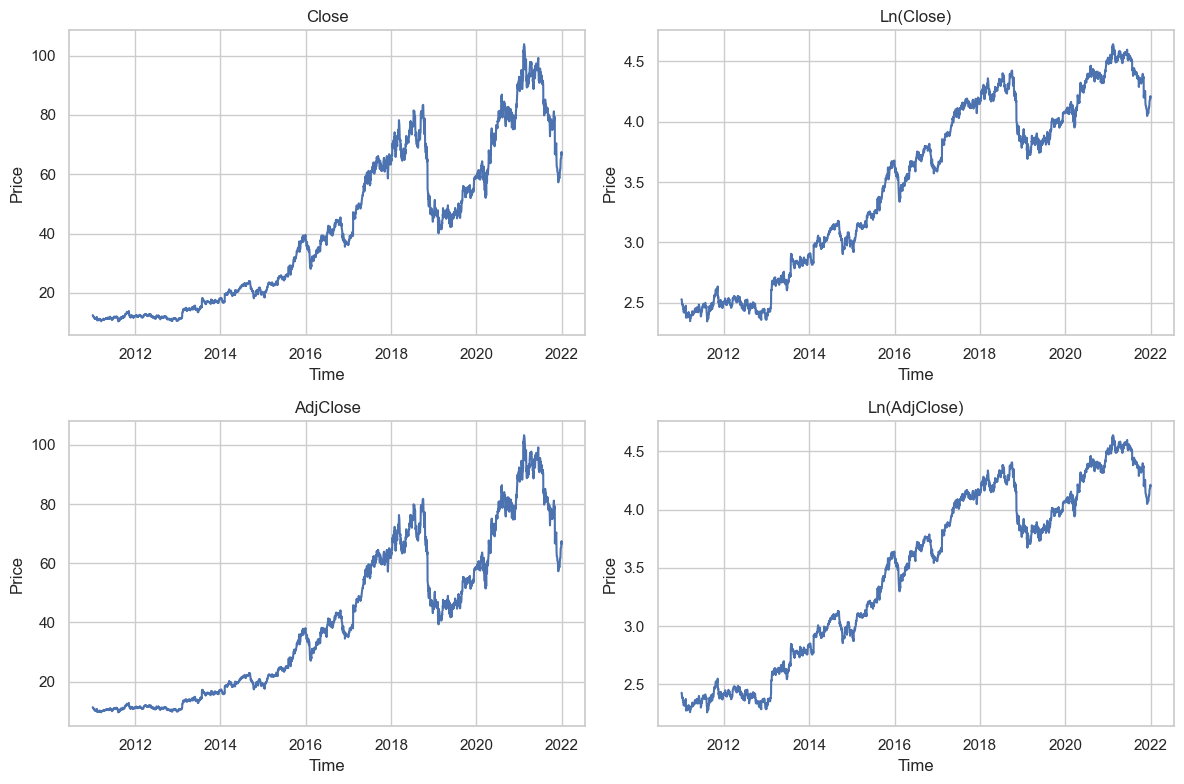

In [27]:
#Visualization of data
# Set up 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Top-left: Close
axs[0, 0].plot(df.index, df["Close"])
axs[0, 0].set_title("Close")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Price")

# Top-right: Ln(Close)
axs[0, 1].plot(df.index, np.log(df["Close"]))
axs[0, 1].set_title("Ln(Close)")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Price")

# Bottom-left: Adjusted Close
axs[1, 0].plot(df.index, df["Adjusted"])
axs[1, 0].set_title("AdjClose")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Price")

# Bottom-right: Ln(AdjClose)
axs[1, 1].plot(df.index, np.log(df["Adjusted"]))
axs[1, 1].set_title("Ln(AdjClose)")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Price")

# Adjust layout
plt.tight_layout()

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/price_plots.png", dpi=300)

plt.show()

The patterns do not appear to exhibit significant differences in terms of their behavior, as per the Random Walk (RW) style analysis. However, there are variations in the values.

To mitigate the impact of dividends, we will analyze the adjusted values, which account for the dividend effect.

We will employ a logarithmic scale for the following reasons:

- allows for a clearer visualization of changes and fluctuations.

- because it aligns returns with prices on a logarithmic scale, as they
  represent the first differences of logarithmic prices
  (log(Close).diff())).
  
From this point onward, our analysis will focus on log(Adjusted) values.

In [28]:
df["Adjusted_log"]=np.log(df["Adjusted"])
df["Close_log"]=np.log(df["Close"])

The Figures are showing a trend of “adjusted” prices, the one on the right is in a logarithmic scale often preferred because it better captures the variations. A growing trend emerges interrupted by negative phases in 2019 and 2021.

The data appear to be non-stationary, a fact confirmed by below analysis of ACF and PACF graphs.

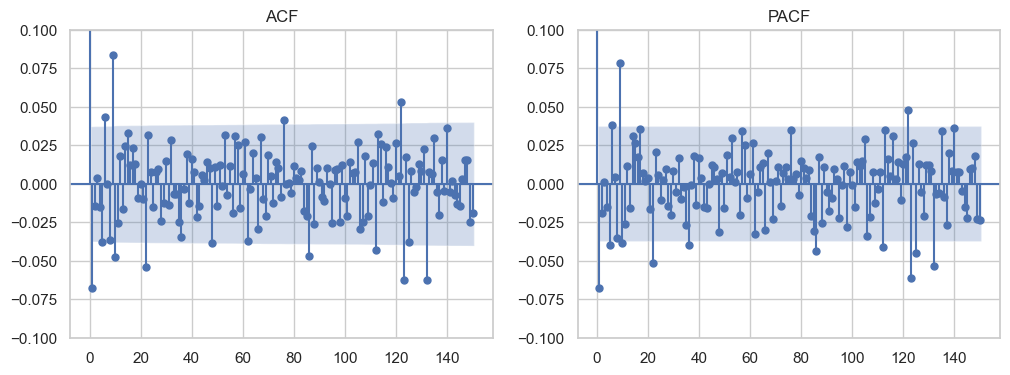

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(df["Adjusted_log"].diff())[1:], lags=150, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(np.array(df["Adjusted_log"].diff())[1:], lags=150, ax=axes[1],method='yw') # PACF
axes[1].set_title("PACF") 
axes[1].set_ylim([-0.1,0.1])

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/ACF_PACF_Adjusted_log.png", dpi=300)
plt.show()

However, unlike in the original project this doesn't seem like an AR(1) process!

In [33]:
#For statistical analysis, we will use a customized ADF function (dodać do globalnych później? No i może reference)

def adf_test(series, max_aug=10, version='n'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 500:
                cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 500:
                cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 500:
                cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

        results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [34]:
#ADF test with trend
adf_test(df["Adjusted_log"], max_aug=20, version='t')

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-1.9857330255,-3.9630000000,-3.4130000000,-3.1280000000,0.0038000000,0.0000000000,0.0000000000
1,1,-1.7968980169,-3.9630000000,-3.4130000000,-3.1280000000,0.3228000000,0.0001000000,0.0002000000
2,2,-1.7282890814,-3.9630000000,-3.4130000000,-3.1280000000,0.4879000000,0.0002000000,0.0003000000
3,3,-1.7292768609,-3.9630000000,-3.4130000000,-3.1280000000,0.1952000000,0.0002000000,0.0002000000
4,4,-1.6768115784,-3.9630000000,-3.4130000000,-3.1280000000,0.1444000000,0.0003000000,0.0003000000
5,5,-1.5583455540,-3.9630000000,-3.4130000000,-3.1280000000,0.0031000000,0.0005000000,0.0008000000
6,6,-1.6617631666,-3.9630000000,-3.4130000000,-3.1280000000,0.0003000000,0.0024000000,0.0023000000
7,7,-1.6758449158,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0002000000,0.0017000000
8,8,-1.5812564408,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0027000000,0.0020000000
9,9,-1.7943383888,-3.9630000000,-3.4130000000,-3.1280000000,0.1978000000,0.0756000000,0.2133000000


In [ ]:
#interpretation of table: assuming that p-value is 5%, then we will analyse 9th lag 
#(then, in BG test, null hypothesis of no autocorrelation of residuals upholds)

#Looking at ADF test statistic we can conclude that 'Adjusted_log' variable is non-stationary (ADF test statistic doesn't 'fall' 
#into critical value interval).

#As a result, we need to analyse first difference of 'Adjusted_log' variable!

In [40]:
#ADF test for first differences
adf_test(df["Adjusted_log"].diff(), max_aug=20, version='t')

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.2647404473,-3.9630000000,-3.4130000000,-3.1280000000,0.2629000000,0.0001000000,0.0002000000
1,1,-39.1498693455,-3.9630000000,-3.4130000000,-3.1280000000,0.4230000000,0.0002000000,0.0003000000
2,2,-31.3510866693,-3.9630000000,-3.4130000000,-3.1280000000,0.2330000000,0.0002000000,0.0002000000
3,3,-27.3311339545,-3.9630000000,-3.4130000000,-3.1280000000,0.1168000000,0.0003000000,0.0004000000
4,4,-25.2325198086,-3.9630000000,-3.4130000000,-3.1280000000,0.0034000000,0.0005000000,0.0010000000
5,5,-21.8917454472,-3.9630000000,-3.4130000000,-3.1280000000,0.0004000000,0.0024000000,0.0026000000
6,6,-20.1057660968,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0002000000,0.0020000000
7,7,-19.4254632397,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0035000000,0.0027000000
8,8,-16.8581380447,-3.9630000000,-3.4130000000,-3.1280000000,0.1824000000,0.0891000000,0.2402000000
9,9,-16.6793587283,-3.9630000000,-3.4130000000,-3.1280000000,0.5333000000,0.4416000000,0.6132000000


In [ ]:
#interpretation of table: assuming that p-value is 5%, then we will analyse again 9th lag 
#(then, in BG test, null hypothesis of no autocorrelation of residuals upholds)

#Looking at ADF test statistic we can conclude that first differences of variable are stationary (ADF test statistic 'falls' 
#into critical value interval).

#As a result, we can conclude that 'Adjusted_log' is a ~I(1) process.
#This conclusion is typical in time series of daily prices of financial assets

## Preliminary analyses of log-returns

In [41]:
# Percentage log-returns
df['yret'] = 100 * df['cc_ret']

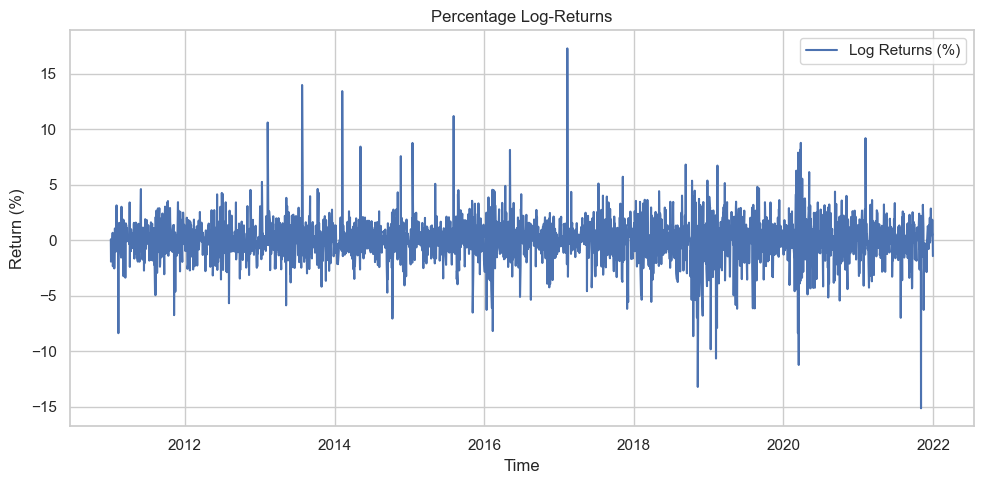

In [42]:
#Plot for variable
plt.figure(figsize=(10, 5))
plt.plot(df['yret'], label="Log Returns (%)")
plt.title("Percentage Log-Returns")
plt.xlabel("Time")
plt.ylabel("Return (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/Log_returns_plot.png", dpi=300)
plt.show()

Comments: 
1) Daily returns move around a mean close to zero similarly to a White Noise process with a lot of heteroskedactisity and mean close to 0
2) There are periods with different variability around the mean (sometimes high, sometimes low) -> volatility clustering will be necessary
3) Data doesn't seem to have been affected by the Covid-19 crisis (argueable)

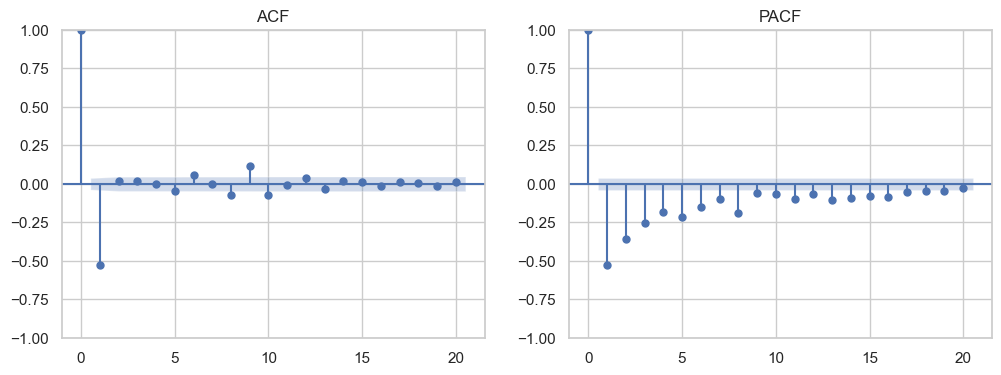

In [51]:
# Ensure no NaNs are passed to the plots
yret_clean = df['yret'].dropna().diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

# ACF
plot_acf(yret_clean, lags=20, ax=axes[0]) #change of lag and limits for petter visualisation
axes[0].set_title("ACF")

# PACF
plot_pacf(yret_clean, lags=20, ax=axes[1], method='yw')
axes[1].set_title("PACF")

# Save before show
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_PACF_log_returns.png", dpi=300)

plt.show()

The results also seem to be different from the ones obtained in original project!

In [53]:
# Ljung-Box statistics on log-returns
# Set parameters
npar = 0
lags = [2, 5, 10, 15, 20, 30, 50]  # already includes npar=0

# Run Ljung-Box test
lb_test = acorr_ljungbox(yret_clean, lags=lags, return_df=True)

# Optionally extract and print key rows
lb_result = lb_test[['lb_stat', 'lb_pvalue']]
lb_result.index = [f"Lag {lag}" for lag in lags]
print(lb_result)

              lb_stat    lb_pvalue
Lag 2  763.9852302049 0.0000000000
Lag 5  771.3242038738 0.0000000000
Lag 10 847.8017124370 0.0000000000
Lag 15 856.3920861044 0.0000000000
Lag 20 858.1956269723 0.0000000000
Lag 30 882.4216090506 0.0000000000
Lag 50 910.4323634375 0.0000000000


Comment: All lags statistically significant but it is quite uncommon 

A further check should be do an ADF test on returns to check whether it is also a ~I(1) process

In [55]:
#ADF test with trend
adf_test(df["yret"], max_aug=20, version='t')

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.2647404473,-3.9630000000,-3.4130000000,-3.1280000000,0.2629000000,0.0001000000,0.0002000000
1,1,-39.1498693455,-3.9630000000,-3.4130000000,-3.1280000000,0.4230000000,0.0002000000,0.0003000000
2,2,-31.3510866693,-3.9630000000,-3.4130000000,-3.1280000000,0.2330000000,0.0002000000,0.0002000000
3,3,-27.3311339545,-3.9630000000,-3.4130000000,-3.1280000000,0.1168000000,0.0003000000,0.0004000000
4,4,-25.2325198086,-3.9630000000,-3.4130000000,-3.1280000000,0.0034000000,0.0005000000,0.0010000000
5,5,-21.8917454472,-3.9630000000,-3.4130000000,-3.1280000000,0.0004000000,0.0024000000,0.0026000000
6,6,-20.1057660968,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0002000000,0.0020000000
7,7,-19.4254632397,-3.9630000000,-3.4130000000,-3.1280000000,0.0002000000,0.0035000000,0.0027000000
8,8,-16.8581380447,-3.9630000000,-3.4130000000,-3.1280000000,0.1824000000,0.0891000000,0.2402000000
9,9,-16.6793587283,-3.9630000000,-3.4130000000,-3.1280000000,0.5333000000,0.4416000000,0.6132000000


In [ ]:
#interpretation of table: assuming that p-value is 5%, then we will analyse again 8th lag 
#(then, in BG test, null hypothesis of no autocorrelation of residuals upholds)

#Looking at ADF test statistic we can conclude that 'yret' variable is stationary (ADF test statistic 'falls' 
#into critical value interval).

#As a result, we can conclude that 'yret' is actually a ~I(0) process, as in original report

In here, the authors conduct test of independence of returns with BDS test- unfortunately it is not implemented in arch Python package, therefore we cocnluded on the previously performed Ljung-Box test

## ARCH test on demeaned log-returns

In [68]:
yret_demeaned = yret_clean - yret_clean.mean()

lags = [4, 8, 12, 16]

results = []
for lag in lags:
    test_stat, p_value, _, _ = het_arch(yret_demeaned, nlags=lag)
    results.append({'lag': lag, 'arch_stat': test_stat, 'p_value': p_value})

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df.head(3))  # equivalent to R's at[1:3,]

   lag      arch_stat      p_value
0    4 763.5630539395 0.0000000000
1    8 785.2001120865 0.0000000000
2   12 789.1451229807 0.0000000000


Results: variables largely significant at all lags indicates the fact that there is no IID ? Authors with similar results conclude that returns are heteroskedastic

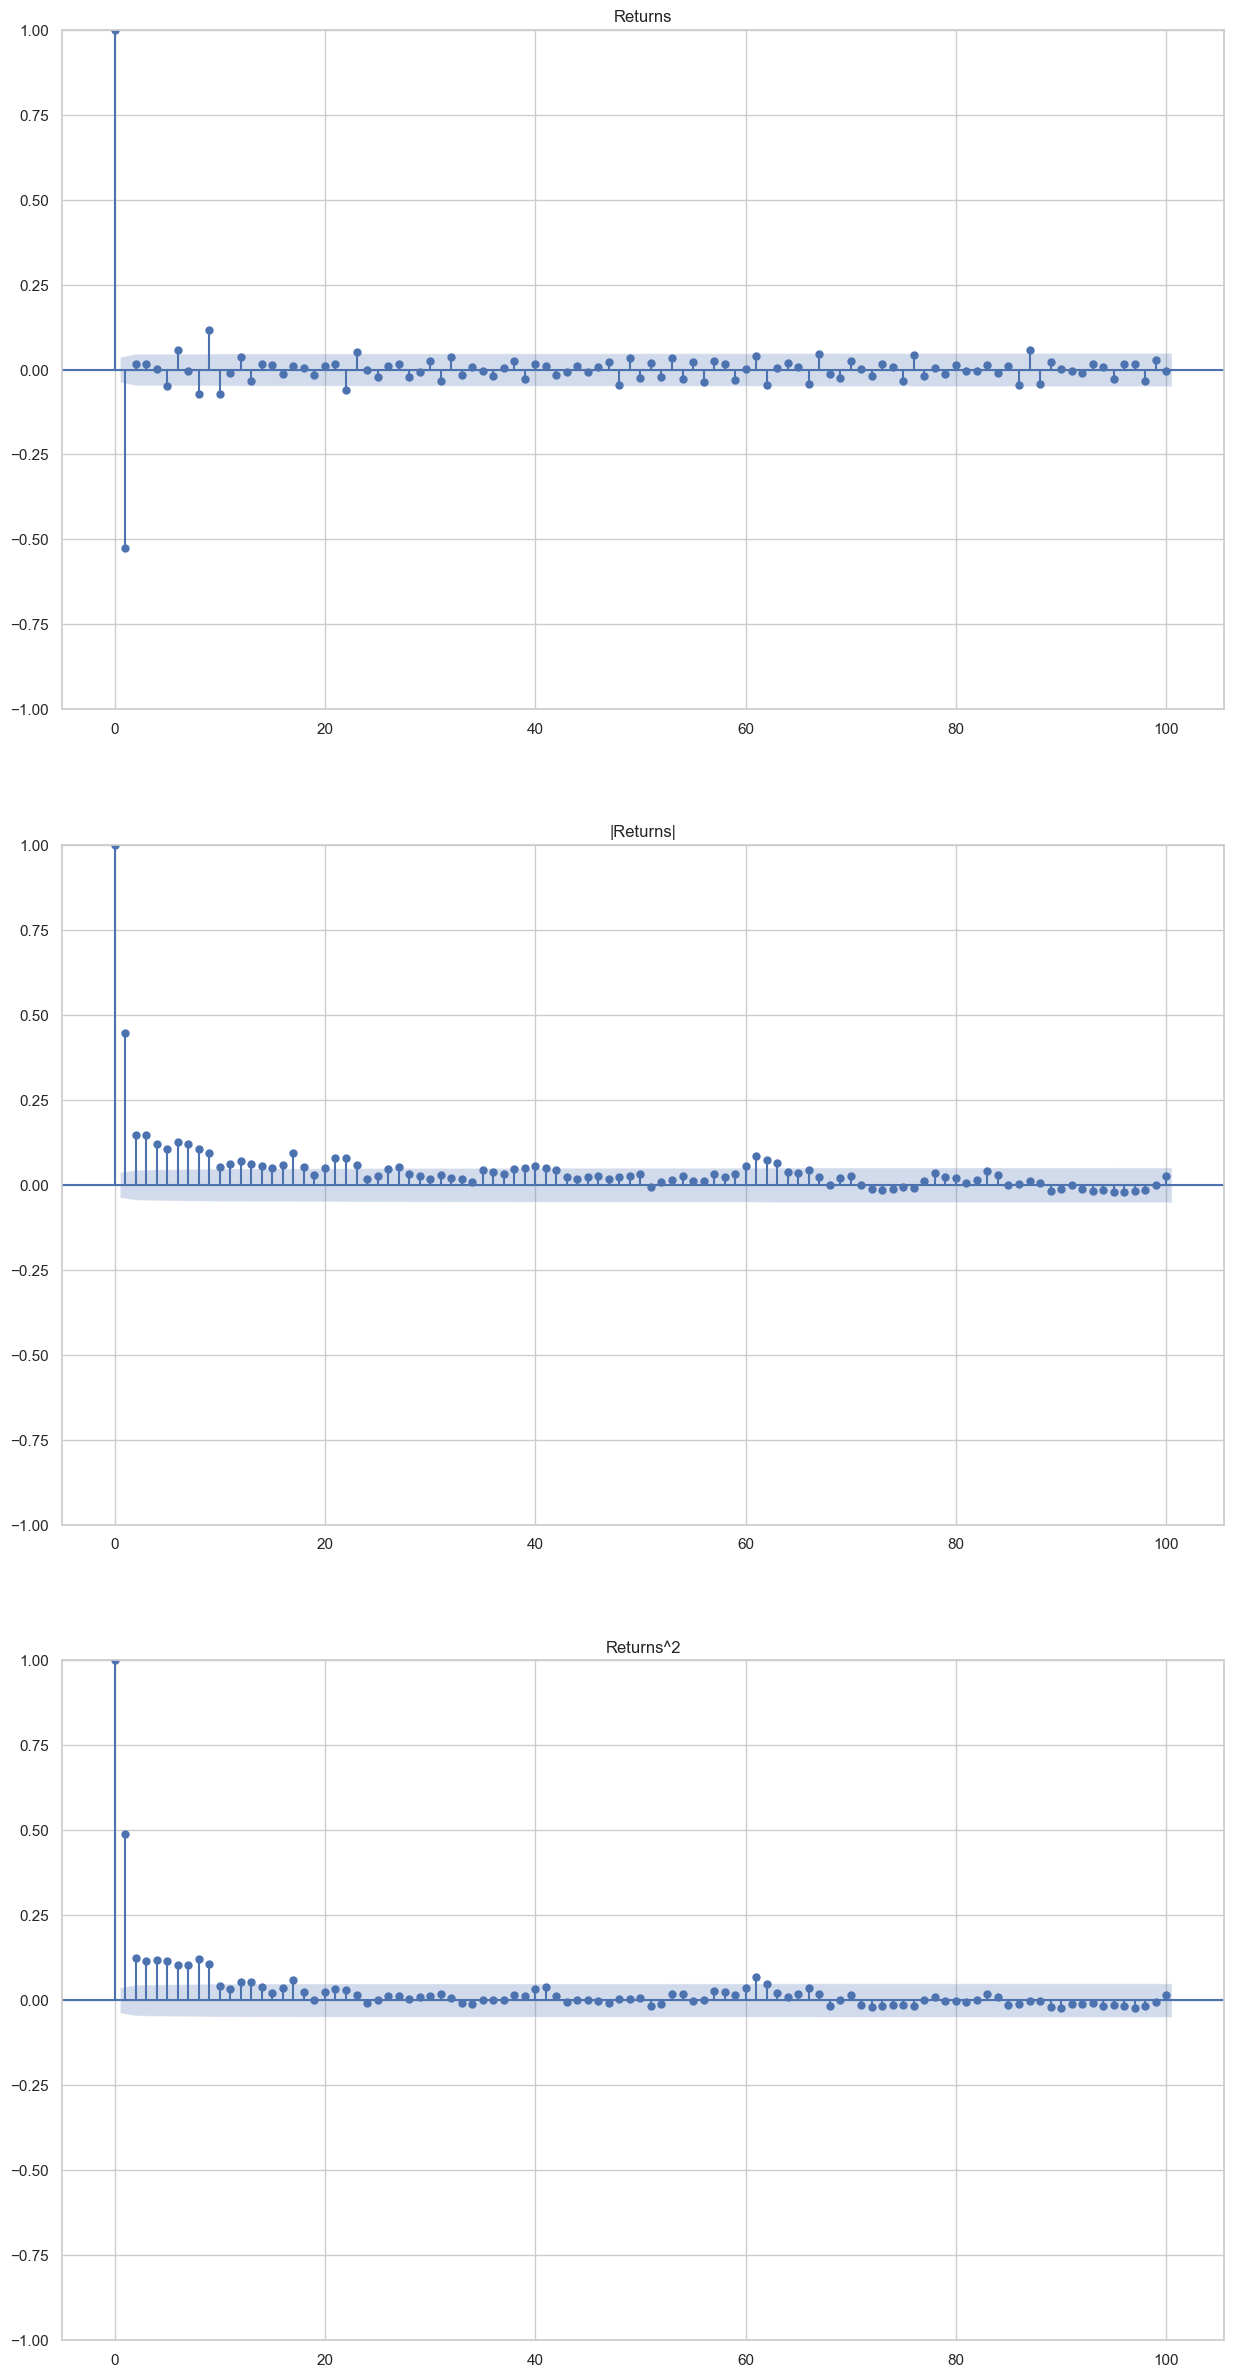

In [73]:
# ACF of residuals, abs residuals and squared residuals
fig, axes = plt.subplots(3, 1, figsize=(15,30)) 

# ACF
plot_acf(yret_clean, lags=100, ax=axes[0]) #change of lag and limits for petter visualisation
axes[0].set_title("Returns")

plot_acf(abs(yret_clean), lags=100, ax=axes[1]) 
axes[1].set_title("|Returns|")

plot_acf(yret_clean*yret_clean, lags=100, ax=axes[2]) 
axes[2].set_title("Returns^2")

# Save before show
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)
plt.savefig(f"{output_folder}/ACF_returns_abs_squared.png", dpi=300)

plt.show()

Plots slightly differs from the ones provided by authors, but nevertheless returns of all types show very slow decay #spojrzeć
This certifies volatility clustering in terms of autocorrelation-Heteroscedasticity
(it is more visible for absolute nad squared returns)

NameError: name 'ddist' is not defined

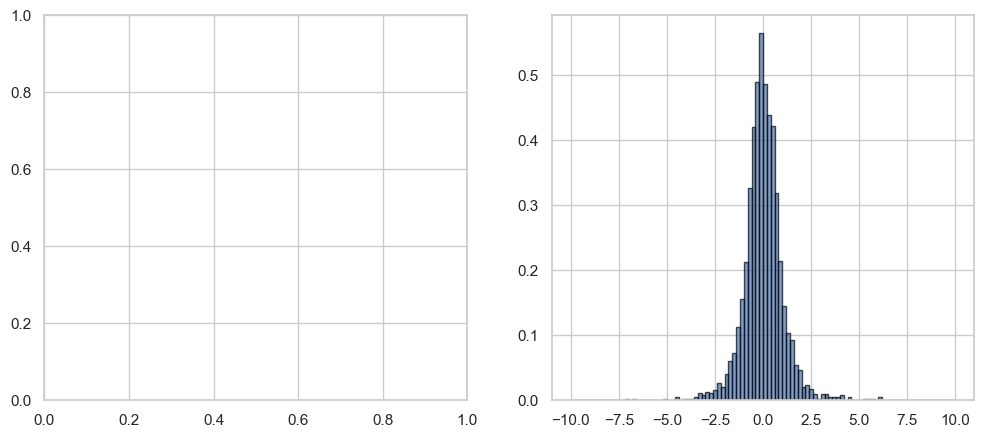

In [82]:
# Unconditional distribution- using TSA_Finance_Function notebook (NAPRAWIĆ)
class DummyFit:
    def __init__(self, z, dist_name='norm', coef=None):
        self.fit = type('fit', (object,), {'z': z, 'coef': coef or {}})
        self.model = type('model', (object,), {
            'modeldesc': {'distribution': dist_name}
        })
        
dummy_coef = {
    'lambda': -0.5,
    'skew': 1,
    'shape': 2
}

fit_yret = DummyFit(z=(yret_clean - np.mean(yret_clean)) / np.std(yret_clean),  # standardized
                    dist_name='norm',  # or 't', 'ged', etc.
                    coef=dummy_coef)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
TSA_Finance_Functions.plot_hist_fit(fit_yret, xlim=[-10, 10], bins=100, plot_norm=True)

# QQ-plot- using TSA_Finance_Function notebook
TSA_Finance_Functions.qqplot_fit(fit_yret)

plt.tight_layout()
plt.show()

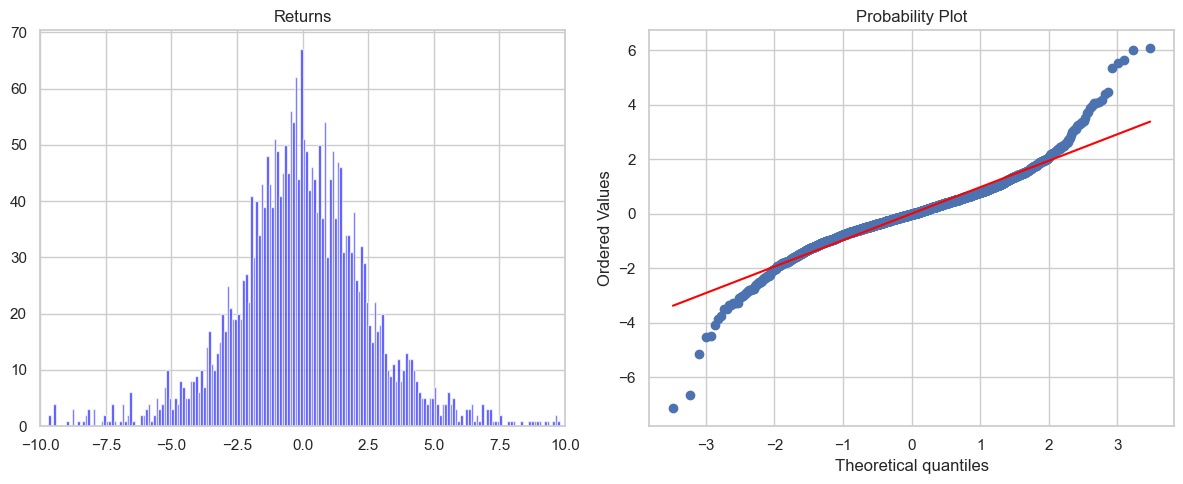

In [83]:
#Alternatively, with pre-build functions
# Scale (standardize) yret like R's scale()
scaler = StandardScaler()
yret_scaled = scaler.fit_transform(yret_clean.values.reshape(-1, 1)).flatten()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
axs[0].hist(yret_clean, bins=200, range=(-10, 10), color='blue', alpha=0.7)
axs[0].set_title('Returns')
axs[0].set_xlim(-10, 10)

# QQ-plot
probplot(yret_scaled, plot=axs[1])
axs[1].get_lines()[1].set_color('red')  # line color

# ✅ Save to file
output_folder = "TSA_GARCH_files_Python"
os.makedirs(output_folder, exist_ok=True)

plt.savefig(f"{output_folder}/Hist_and_QQ_returns.png", dpi=300)

plt.tight_layout()
plt.show()

In [85]:
# Jarque-Bera statistics on log-returns
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(df["yret"].dropna())

print(f"Jarque-Bera test statistic: {jb_stat:.4f}")
print(f"P-value: {jb_pvalue:.4f}")
print(f"Skewness: {skew:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

Jarque-Bera test statistic: 8411.2425
P-value: 0.0000
Skewness: 0.0277
Kurtosis: 11.5397


Comment: Normality is highly rejected; the distribution is leptokurtic. Unconditional return distribution suggests
strong hypernormality (large tails) -> another volatility certification, distribution more similar to t-student than normal

## ARIMA MODELLING